# R-VonFrey up/down calculator

### R script is developend in Andrei V. Chernov's Lab at the University of California San Diego.

#### Version 0.1.beta https://github.com/chernov-lab/VonFreyTest

#### GNU GENERAL PUBLIC LICENSE Applies

#### Observation formats comply with Drs. T.L. Yaksch's (UCSD) and V.I. Shubayev's (UCSD) labs records

##### Parametric data are from Chaplan et al, 1994: 
S R Chaplan  1 , F W Bach, J W Pogrel, J M Chung, T L Yaksh
Quantitative assessment of tactile allodynia in the rat paw
J Neurosci Methods, 1994 Jul;53(1):55-63. doi: 10.1016/0165-0270(94)90144-9.


## Provide file name of the excel file that includes the following tabs:

**data** (XO observations) and

**meta** (comparison setting)

### The **data** spreadsheet stores observation and last filament results
### The **meta** spreadsheet establishes comparison pairs between groups

#### Use the included test_data.xlsx file as a template

**data** table should have the following comumns:

'SEX', 'GROUP', 'PAW', 'TIMEPOINT', 'OBSERVATION', 'LAST', 'ANIMAL_ID'

**meta** table should contain columns 'TREATMENT' and 'REFERENCE'

**Currently only rat calculator is available**

In [91]:
data_file <- "test_data.xlsx"  # <<<- provide excel file name with VF data. File should be uploaded in the main folder

In [92]:
if (file.exists(data_file)) {
    sprintf("Observation data: %s", data_file)
} else { 
    stop(sprintf("File %s does not exist", data_file))
}

[1] "Observation data: test_data.xlsx"

## Set up test parameters:

In [93]:
paw <- 'LEFT' #'RIGHT',  # define paw to use
sex <- "female"  # define sex of animals if needed. Assign "" is sex is not defined
species <- "rat" # define species of animal rat or mouse
post_hoc_method <- "bonferroni" # Allowed values include "holm", "hochberg", "hommel", "bonferroni", "BH", "BY", "fdr", "none". If you don't want to adjust the p value (not recommended), use p.adjust.method = "none".
label_id <- T # set TRUE if want to label animal IDs below threshold

### Define the results file

In [94]:
res_file <- paste('result', data_file, sep='.')  # results file

#### Loading R libraries

In [95]:
library(readr)
library(ggplot2)
library(ggpubr)
library(dplyr)
library(tidyverse)
library(rstatix)
library(DescTools)
library(readxl)
library(writexl)
library(lubridate)
library(emmeans)

### Define some custom functions

In [96]:
`%notin%` <- Negate(`%in%`)

acPage = function(w1=12, h1=6, r1=1, c1=1, m1=2, m2=2, m3=2, m4=2){
  options(repr.plot.width=w1, repr.plot.height= h1) 
  par(mfrow=c(r1,c1), mar=c(m1,m2,m3,m4))
}

### Folder definitions

In [97]:
main_folder = ""
data_folder <- "files"
par_folder <- "parameters"

sex <- toupper(sex)

if (species == "rat"){
    pain_threshold <- 5
    max_res <- 15
}

### Functions for Von Frey Test calculations

In [98]:
XO_file <- paste(species, "final.previous.filaments.XO.csv", sep='.')
stat_file <- paste(species, "observation-statistics.csv", sep='.')

observation_table <- read.csv(file.path(par_folder, stat_file), row.names=1, stringsAsFactors=FALSE)
XO.table <- read.csv(file.path(par_folder, XO_file), row.names=1, stringsAsFactors=FALSE)

VonFrey = function(obs='', last=0){
    obs <- toupper(obs)
    res <- 0
    if (obs == '' | last == 0) { return (-1)} 
    else if (obs == 'OOOOO' & last == 5.18) { res <- max_res } 
    else if (obs == 'XXXX' & last == 3.61) { res <- 0.2 }
    else if (length(which(rownames(XO.table) == last)) == 0 | length(which(rownames(observation_table) == obs))== 0) { return (-1)}
    else {
        a <- substr(obs, nchar(obs)-1, nchar(obs)-1)
        prev <- XO.table[which(rownames(XO.table) == last), a]
        dif <- abs(last - prev)
        p50 <- last + dif * observation_table[which(rownames(observation_table) == obs),'STATISTIC']
        res <- (10**p50)/10000
        if (res > 15) { res <- max_res }
        if (res < 0.2) { res <- 0.20 }
        return(as.numeric(sprintf("%.2f", res)))
    }
}

TruncateObservation = function(obs = '', met = 2){
    obs <- toupper(obs)
    if (obs == '') { return ("") } 
    if (met == 2) { return (obs) }
    if (met == 1) {  # Jenny's short method
        len <- nchar(obs)  
        Xpos <- StrPos(obs, 'X') 
        if (is.na(Xpos)) { return (obs) }   
        obs1 <- substr(obs, Xpos, len) 
        return (obs1)
    }
}

## Read DATA and META files from main folder

In [99]:
dt <- readxl::read_excel(data_file, sheet = "data") 
meta <- readxl::read_excel(data_file, sheet = "meta")

In [100]:
dt <- dt %>% rename_with(toupper)
meta <- meta %>% rename_with(toupper)

# convert key parameters to uppercase
dt <- dt %>% dplyr::mutate (
                DATE = ymd(DATE),
                SEX = toupper(SEX), 
                OBSERVATION = toupper(OBSERVATION),
                PAW = toupper(PAW))
dt <- dt %>% dplyr::arrange(SEX, TIMEPOINT, PAW)
head(dt)
head(meta)

DATE,SPECIES,SEX,GROUP,ANIMAL_ID,CAGE,NOTCH,PAW,TIMEPOINT,OBSERVATION,LAST
<date>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
2022-01-13,RAT,FEMALE,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74
2022-01-13,RAT,FEMALE,A,AC226,1,R,LEFT,0,OOOOO,5.18
2022-01-13,RAT,FEMALE,A,AC227,1,N,LEFT,0,OOOOXOXOX,5.18
2022-01-14,RAT,FEMALE,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74
2022-01-14,RAT,FEMALE,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74
2022-01-14,RAT,FEMALE,A,AC342,7,N,LEFT,0,OOOOXOXXO,4.74


COMPARISON,TREATMENT,REFERENCE,SPECIES,SEX
<dbl>,<chr>,<chr>,<chr>,<chr>
1,B,E,RAT,FEMALE
2,B,A,RAT,FEMALE
3,C,E,RAT,FEMALE
4,C,A,RAT,FEMALE
5,D,E,RAT,FEMALE
6,D,A,RAT,FEMALE


### filter by specific sex if **sex** is assigned

In [101]:
if (sex != ""){ dt <- dt %>% filter (SEX == sex) }

### Calculate **Von Frey Test** values

In [102]:
dt <- dt %>% dplyr::mutate(RESULT = mapply(VonFrey, OBSERVATION, LAST))

In [103]:
head(dt, 5)

DATE,SPECIES,SEX,GROUP,ANIMAL_ID,CAGE,NOTCH,PAW,TIMEPOINT,OBSERVATION,LAST,RESULT
<date>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
2022-01-13,RAT,FEMALE,A,AC225,1,L,LEFT,0,OOOOXXOXO,4.74,8.34
2022-01-13,RAT,FEMALE,A,AC226,1,R,LEFT,0,OOOOO,5.18,15.00
2022-01-13,RAT,FEMALE,A,AC227,1,N,LEFT,0,OOOOXOXOX,5.18,11.66
2022-01-14,RAT,FEMALE,A,AC340,7,L,LEFT,0,OOOOXXOXO,4.74,8.34
2022-01-14,RAT,FEMALE,A,AC341,7,R,LEFT,0,OOOOXXOXO,4.74,8.34


### Check for errors reported by Von Frey calculator
#### Negative RESULTs (-1) indicate an error most likely related to incorrect XO data entry

In [104]:
dt %>% filter(RESULT < 0)

DATE,SPECIES,SEX,GROUP,ANIMAL_ID,CAGE,NOTCH,PAW,TIMEPOINT,OBSERVATION,LAST,RESULT
<date>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>


### Prepare dataset for ANOVA analysis and plotting

In [105]:
dt <- dt %>% filter(RESULT > 0)
lp_dt_names <- c('SEX', 'GROUP', 'PAW', 'TIMEPOINT', 'RESULT', 'ANIMAL_ID')
lp_meta_names <- c('COMPARISON', 'TREATMENT', 'REFERENCE')

In [106]:
lp <- dt %>% 
    select(all_of(lp_dt_names)) %>% 
        mutate(DAY = TIMEPOINT, 
        TIMEPOINT = as.integer(TIMEPOINT),
        DAY = factor(TIMEPOINT),
        GROUP = factor(GROUP),
    ID = row_number()) %>% 
    print

# A tibble: 480 × 8
   SEX    GROUP PAW   TIMEPOINT RESULT ANIMAL_ID DAY      ID
   <chr>  <fct> <chr>     <int>  <dbl> <chr>     <fct> <int>
 1 FEMALE A     LEFT          0   8.34 AC225     0         1
 2 FEMALE A     LEFT          0  15    AC226     0         2
 3 FEMALE A     LEFT          0  11.7  AC227     0         3
 4 FEMALE A     LEFT          0   8.34 AC340     0         4
 5 FEMALE A     LEFT          0   8.34 AC341     0         5
 6 FEMALE A     LEFT          0   9.49 AC342     0         6
 7 FEMALE B     LEFT          0   8.34 AC228     0         7
 8 FEMALE B     LEFT          0  13.8  AC229     0         8
 9 FEMALE B     LEFT          0  15    AC330     0         9
10 FEMALE B     LEFT          0  11.7  AC343     0        10
# … with 470 more rows


### Set up comparison pairs

In [107]:
meta <- meta %>% 
    mutate(COMPARISON = mapply(sprintf, "%s-%s", TREATMENT, REFERENCE)) %>% 
    print

# A tibble: 6 × 5
  COMPARISON TREATMENT REFERENCE SPECIES SEX   
  <chr>      <chr>     <chr>     <chr>   <chr> 
1 B-E        B         E         RAT     FEMALE
2 B-A        B         A         RAT     FEMALE
3 C-E        C         E         RAT     FEMALE
4 C-A        C         A         RAT     FEMALE
5 D-E        D         E         RAT     FEMALE
6 D-A        D         A         RAT     FEMALE


In [108]:
mt <- meta %>% 
    select (TREATMENT, REFERENCE) %>% 
    t
comparisons <- lapply(seq_len(ncol(mt)), function(i) mt[,i])

### Filter by LEFT or RIGHT paw

In [109]:
if (paw != "") { lp <- lp %>% filter(PAW == paw) }

In [110]:
min_res <- lp %>% 
    select (RESULT) %>% 
    min
max_res <- lp %>% 
    select (RESULT) %>% 
    max

## Summary statistics
Compute some summary statistics (count, mean and sd) of the variable weight organized by groups:

# Two-way ANOVA

## Summary statistics
Compute the mean and the SD (standard deviation) of the score by groups:

In [111]:
lp_stat <- lp %>%
    group_by(GROUP, DAY) %>%
    get_summary_stats(RESULT, type = "mean_se") %>% 
    mutate (TIMEPOINT = as.numeric(strtoi(DAY))) %>% 
    print

# A tibble: 40 × 7
   GROUP DAY   variable     n  mean    se TIMEPOINT
   <fct> <fct> <chr>    <dbl> <dbl> <dbl>     <dbl>
 1 A     0     RESULT       6 10.2  1.10          0
 2 A     1     RESULT       6  5.08 1.17          1
 3 A     3     RESULT       6  3.71 0.73          3
 4 A     5     RESULT       6  4.75 0.453         5
 5 A     7     RESULT       6  7.97 1.06          7
 6 A     13    RESULT       6  5.96 1.35         13
 7 A     18    RESULT       6  8.44 1.96         18
 8 A     21    RESULT       6  6.66 1.55         21
 9 B     0     RESULT       6 11.8  1.41          0
10 B     1     RESULT       6  5.08 1.27          1
# … with 30 more rows


## Visualization
Create a box plot of the score by gender levels, colored by education levels:

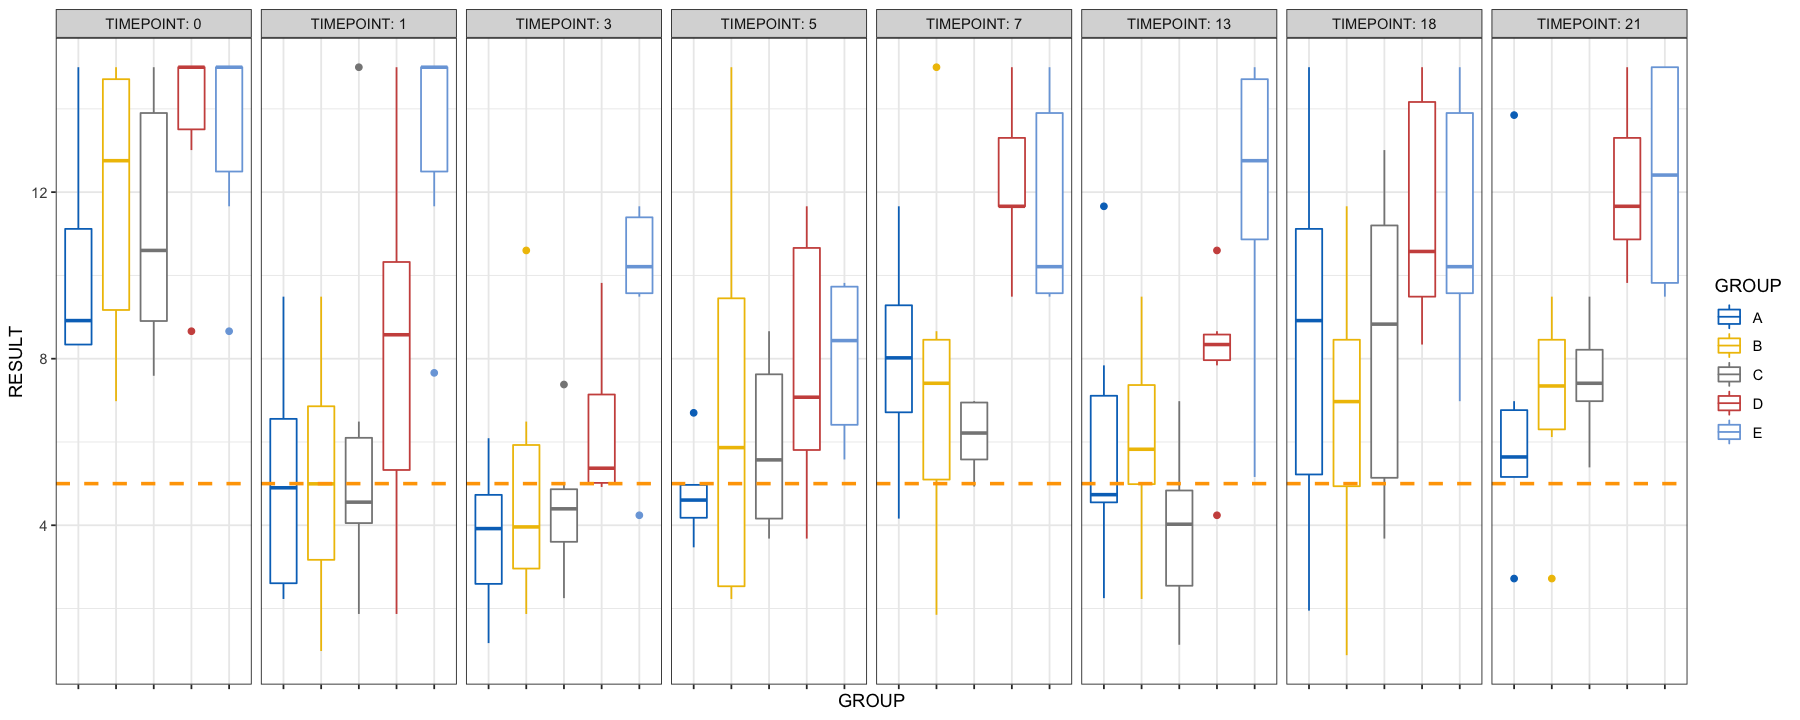

In [112]:
acPage(w1=15, h1=6)
bxp <- lp %>% ggboxplot(
    x = "GROUP", y = "RESULT",
    color = "GROUP", 
    palette = "jco",
    ) +
    theme_bw() +
    rremove("x.text") +
    geom_hline(yintercept=5, linetype="dashed", color = "orange", size=1) +
    facet_grid( ~ TIMEPOINT, labeller = "label_both")

plot(bxp)

In [113]:
lp_outs <- lp %>%
    group_by(GROUP, DAY) %>%
    identify_outliers(RESULT) %>% 
    filter(is.extreme == TRUE) %>% 
    print()

lp <- lp %>% 
    anti_join(lp_outs, by = "ID") %>% 
    print()

# A tibble: 5 × 10
  GROUP DAY   SEX   PAW   TIMEPOINT RESULT ANIMAL_ID    ID is.outlier is.extreme
  <fct> <fct> <chr> <chr>     <int>  <dbl> <chr>     <int> <lgl>      <lgl>     
1 A     21    FEMA… LEFT         21  13.8  AC225       421 TRUE       TRUE      
2 C     1     FEMA… LEFT          1  15    AC333        75 TRUE       TRUE      
3 D     0     FEMA… LEFT          0   8.66 AC336        21 TRUE       TRUE      
4 D     13    FEMA… LEFT         13   4.24 AC336       312 TRUE       TRUE      
5 D     13    FEMA… LEFT         13  10.6  AC349       325 TRUE       TRUE      
# A tibble: 235 × 8
   SEX    GROUP PAW   TIMEPOINT RESULT ANIMAL_ID DAY      ID
   <chr>  <fct> <chr>     <int>  <dbl> <chr>     <fct> <int>
 1 FEMALE A     LEFT          0   8.34 AC225     0         1
 2 FEMALE A     LEFT          0  15    AC226     0         2
 3 FEMALE A     LEFT          0  11.7  AC227     0         3
 4 FEMALE A     LEFT          0   8.34 AC340     0         4
 5 FEMALE A     LEFT        

### Build the linear model

In [114]:
model  <- lm(RESULT ~ GROUP * DAY, data = lp)

## Normality assumption
The normality assumption can be checked by using one of the following two approaches:

* Analyzing the ANOVA model residuals to check the normality for all groups together. This approach is easier and it’s very handy when you have many groups or if there are few data points per group.

* Check normality for each group separately. This approach might be used when you have only a few groups and many data points per group.
In this section, we’ll show you how to proceed for both option 1 and 2.

### Create a QQ plot of residuals

In the QQ plot, as all the points fall approximately along the reference line, we can assume normality. This conclusion is supported by the Shapiro-Wilk test. If the p-value is not significant, we can assume normality.

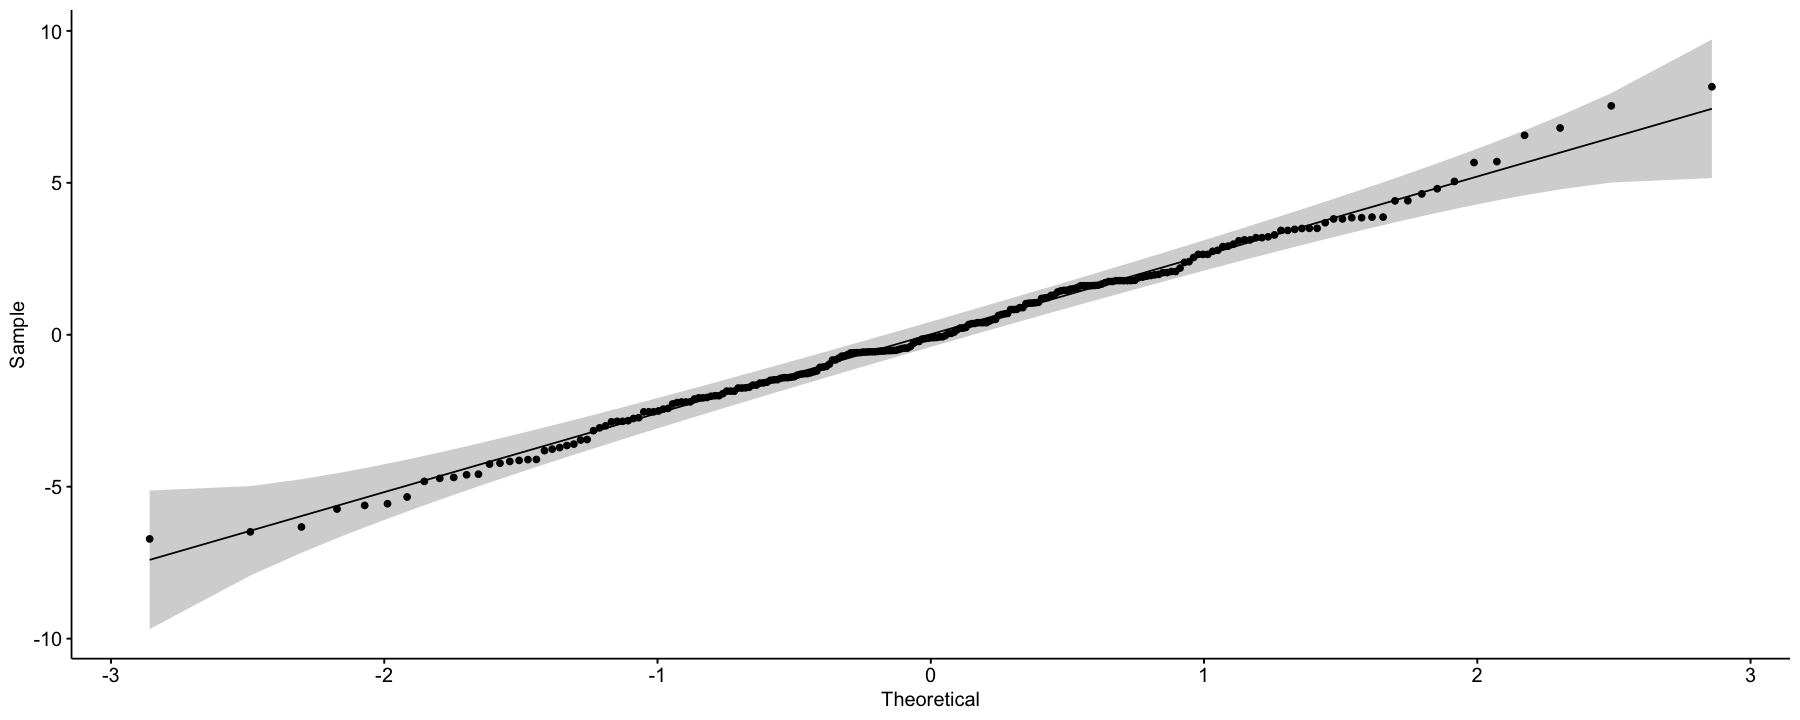

In [115]:
model %>% residuals %>% ggqqplot

### Compute Shapiro-Wilk test of normality

In [116]:
model %>% residuals %>% shapiro_test

variable,statistic,p.value
<chr>,<dbl>,<dbl>
.,0.9952258,0.677305


Check normality assumption by analyzing the model residuals. QQ plot and Shapiro-Wilk test of normality are used. QQ plot draws the correlation between a given data and the normal distribution.

In [117]:
Shapiro <- lp %>% 
    group_by(DAY, GROUP) %>% 
    shapiro_test(RESULT)

Shapiro %>% filter( p < 0.05 ) %>% print()

Shapiro %>% filter( p > 0.05 ) %>% print()

# A tibble: 8 × 5
  GROUP DAY   variable statistic        p
  <fct> <fct> <chr>        <dbl>    <dbl>
1 A     0     RESULT       0.784 0.0417  
2 D     0     RESULT       0.552 0.000131
3 E     0     RESULT       0.704 0.00673 
4 E     1     RESULT       0.695 0.00552 
5 D     3     RESULT       0.788 0.0462  
6 E     3     RESULT       0.776 0.0351  
7 E     7     RESULT       0.735 0.0143  
8 E     21    RESULT       0.707 0.00739 
# A tibble: 32 × 5
   GROUP DAY   variable statistic     p
   <fct> <fct> <chr>        <dbl> <dbl>
 1 B     0     RESULT       0.870 0.226
 2 C     0     RESULT       0.866 0.211
 3 A     1     RESULT       0.912 0.448
 4 B     1     RESULT       0.965 0.856
 5 C     1     RESULT       0.968 0.864
 6 D     1     RESULT       0.989 0.986
 7 A     3     RESULT       0.982 0.962
 8 B     3     RESULT       0.888 0.308
 9 C     3     RESULT       0.955 0.783
10 A     5     RESULT       0.913 0.455
# … with 22 more rows


Check if the scores are normally distributed (p > 0.05) for each group, as assessed by Shapiro-Wilk’s test of normality.

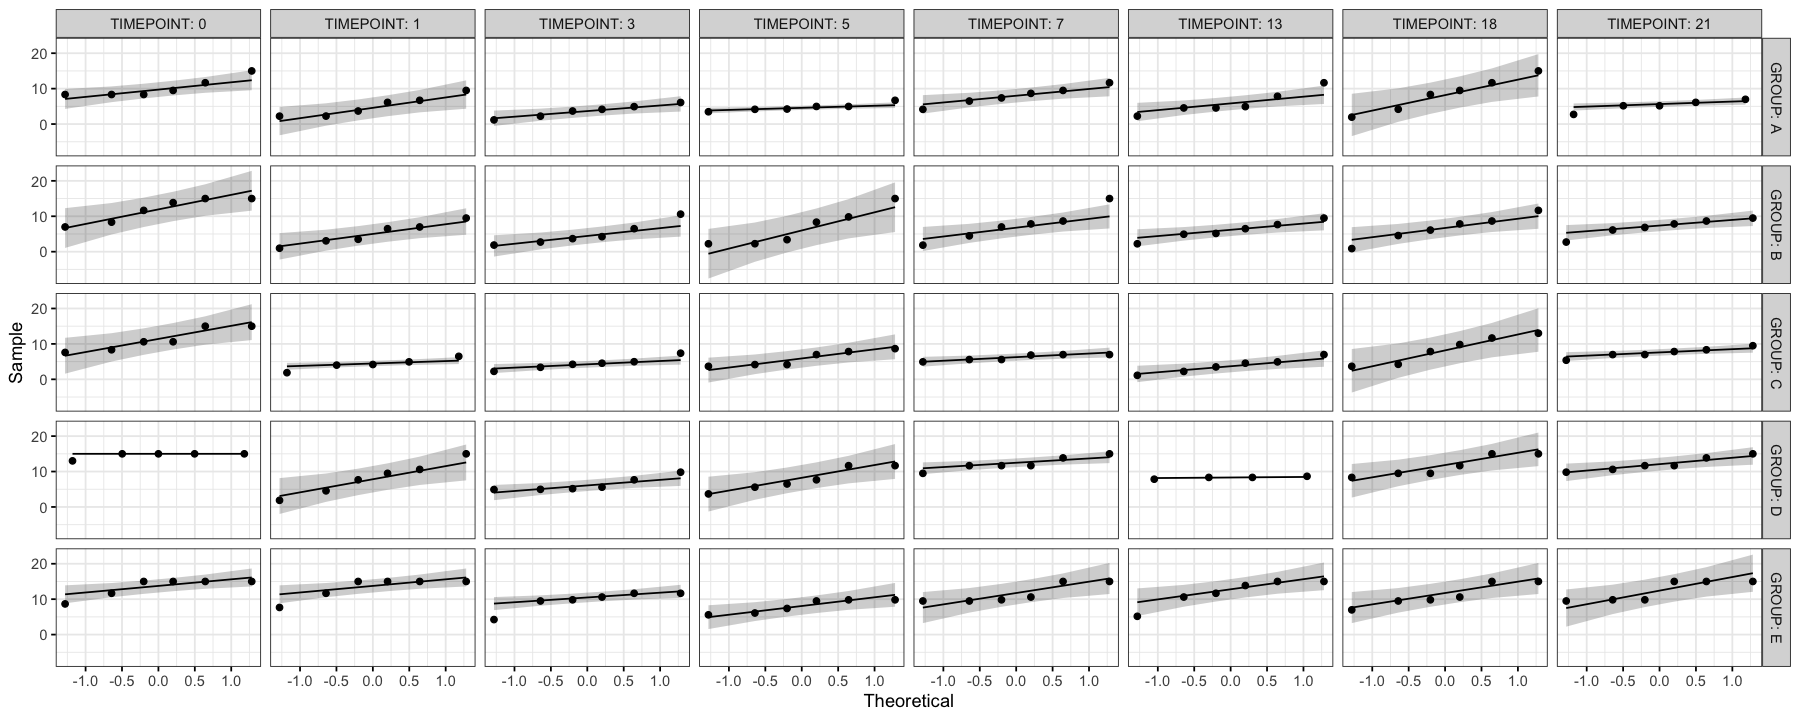

In [118]:
ggqqplot(lp, "RESULT", ggtheme = theme_bw()) +
    facet_grid( GROUP ~ TIMEPOINT, labeller = "label_both")

### Calculate ANOVA statistics table with post hoc corrections 

In [119]:
pwc <- lp %>% 
    group_by(DAY) %>%
    emmeans_test(RESULT ~ GROUP, model = model, 
            comparisons = comparisons,
            p.adjust.method = post_hoc_method) 

pwc_stat <- pwc

### List most significant differences between groups

In [120]:
pwc %>% 
    filter(p.adj < 0.1) %>% 
    arrange (p.adj) %>% 
    print

# A tibble: 15 × 10
   DAY   term  .y.    group1 group2    df statistic       p   p.adj p.adj.signif
   <chr> <chr> <chr>  <chr>  <chr>  <dbl>     <dbl>   <dbl>   <dbl> <chr>       
 1 1     GROUP RESULT C      E        195     -5.07 9.03e-7 5.42e-6 ****        
 2 1     GROUP RESULT B      E        195     -4.85 2.49e-6 1.49e-5 ****        
 3 13    GROUP RESULT C      E        195     -4.77 3.66e-6 2.20e-5 ****        
 4 21    GROUP RESULT D      A        195      3.91 1.29e-4 7.74e-4 ***         
 5 13    GROUP RESULT B      E        195     -3.51 5.57e-4 3.34e-3 **          
 6 7     GROUP RESULT C      E        195     -3.23 1.45e-3 8.70e-3 **          
 7 21    GROUP RESULT B      E        195     -3.23 1.47e-3 8.85e-3 **          
 8 3     GROUP RESULT C      E        195     -3.05 2.60e-3 1.56e-2 *           
 9 1     GROUP RESULT D      E        195     -3.00 3.08e-3 1.85e-2 *           
10 21    GROUP RESULT C      E        195     -2.89 4.24e-3 2.55e-2 *           
11 3    

### Add formatted P-value for graphics

In [121]:
pwc$p.format <- p_format(pwc$p, accuracy = 0.0001, leading.zero = FALSE)
head(pwc)

DAY,term,.y.,group1,group2,df,statistic,p,p.adj,p.adj.signif,p.format
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0,GROUP,RESULT,B,E,195,-0.9432938,0.34669787,1.00000000,ns,.3467
0,GROUP,RESULT,B,A,195,0.9601916,0.33814786,1.00000000,ns,.33815
0,GROUP,RESULT,C,E,195,-1.3110691,0.19137623,1.00000000,ns,.19138
0,GROUP,RESULT,C,A,195,0.5924163,0.55425814,1.00000000,ns,.55426
0,GROUP,RESULT,D,E,195,0.6910844,0.49033438,1.00000000,ns,.49033
0,GROUP,RESULT,D,A,195,2.5059865,0.01302892,0.07817352,ns,.01303


In [122]:
days <- lp %>% select(TIMEPOINT) %>% arrange %>% unique %>% as.list
days

$TIMEPOINT
[1]  0  1  3  5  7 13 18 21

## Plot all data on one graph

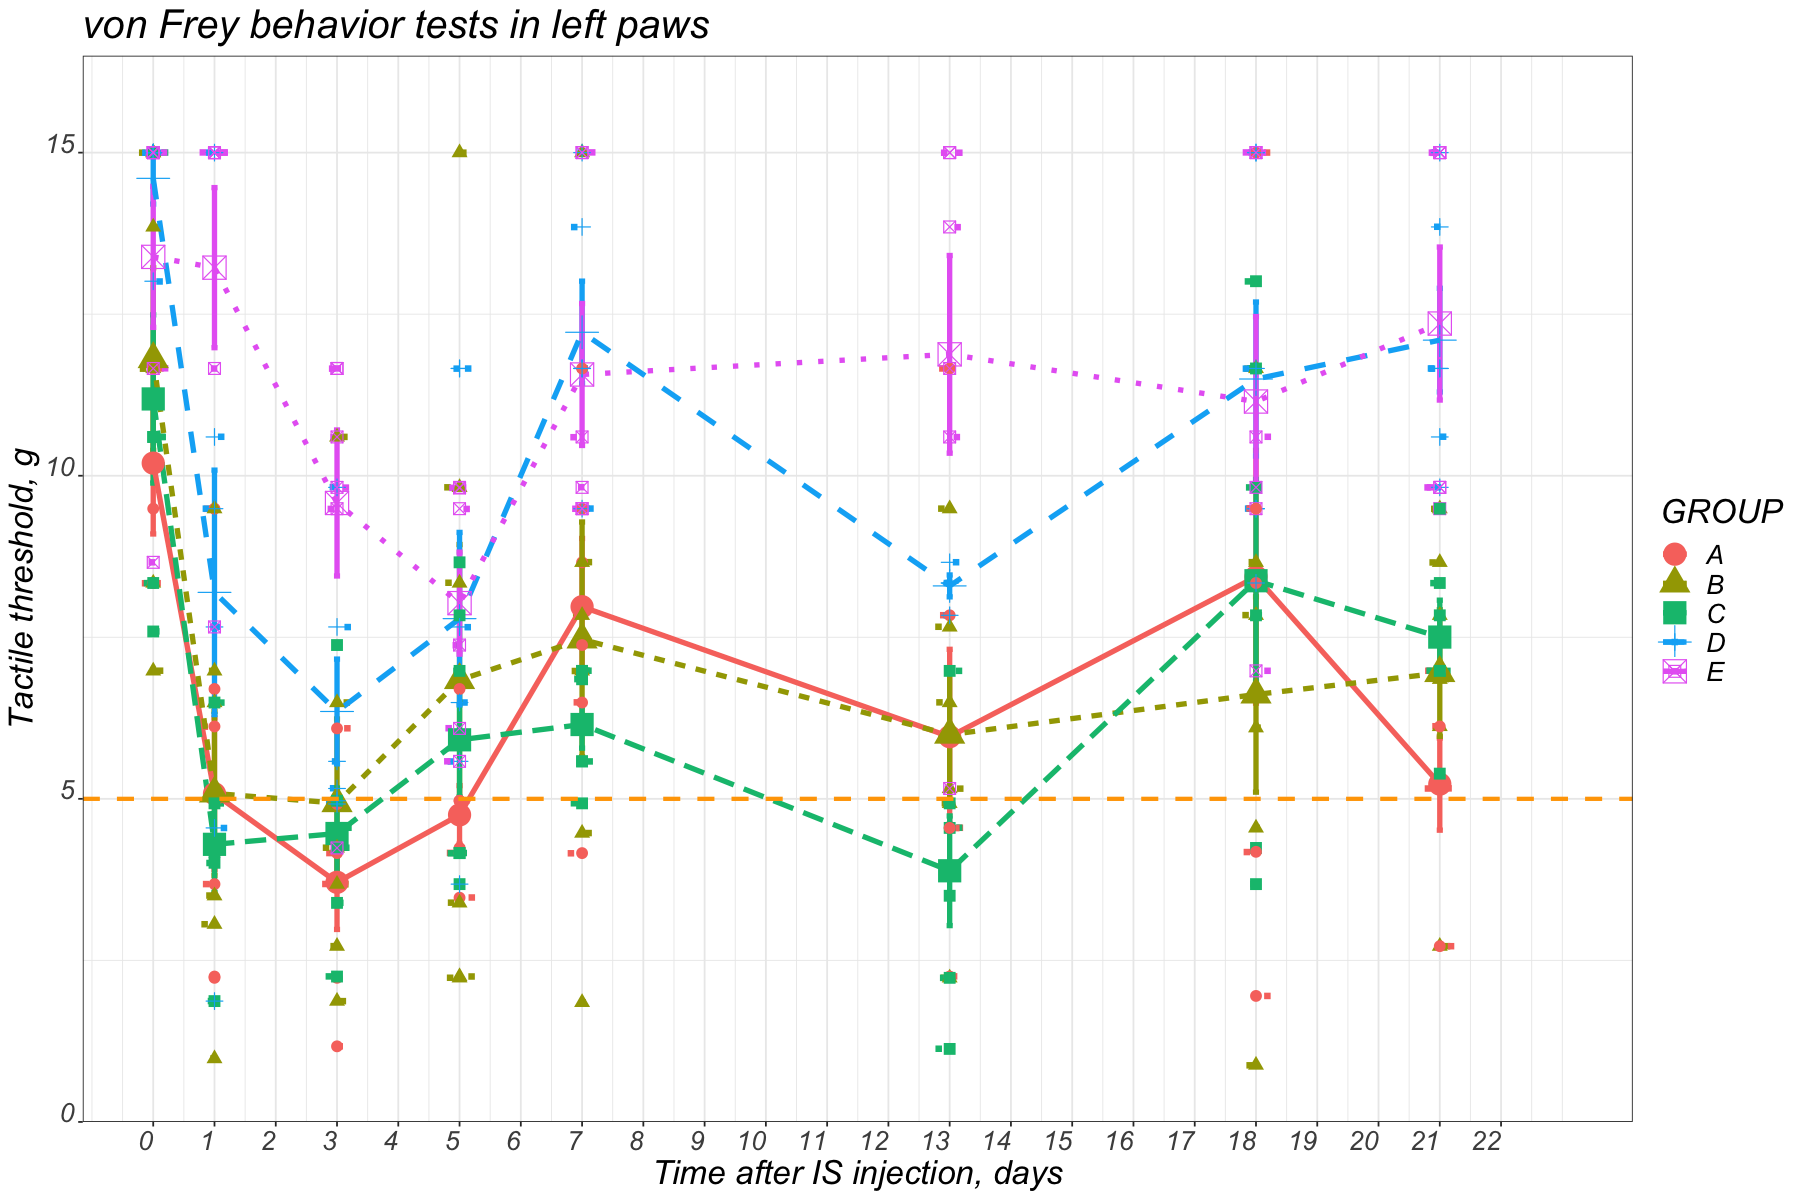

In [123]:
acPage(w1=15, h1=10)

x_max <- max(lp$TIMEPOINT) + 1

p <- ggline(lp, 
            x = "TIMEPOINT",
            y = "RESULT", 
            size = 1.5,            
            color = "GROUP",
            shape = "GROUP",
            point.size = 5,
            linetype = "GROUP",
            ylim = c(0, max_res),
            xlim = c(0, x_max + 1),
            add = c("mean_se", "jitter" ),
            add.params = list(width = 0.1, shape = 15),
            palette = "GROUP"
            )  +
    theme_bw() +
    geom_point(size = 3, aes(color = GROUP, shape = GROUP)) +
    xlab("Time after IS injection, days") +
    ylab("Tactile threshold, g") +
    ggtitle( sprintf( "von Frey behavior tests in %s paws", tolower (paw))) +
    theme(text = element_text(size=20, color = "black", angle = 0, hjust = .5, vjust = 0, face = "italic"),
    axis.text.x = element_text(hjust=1)) +
    geom_hline(yintercept=5, linetype="dashed", color = "orange", size=1.2) +
    scale_y_continuous(breaks= 0 : round(max_res) * max_res/3, expand = expansion(mult = c(0, 0.1))  ) +
    scale_x_continuous(breaks= 0 : x_max * 1) 
plot(p)

### Plot this graph into a PDF file

In [124]:
pdf(sprintf("vonFrey plot.pdf"), width = 15, height = 10)
plot(p)
dev.off()

pdf 
  2

### Ensure X axis coordinates correctly mapped

In [125]:
pwc <- pwc %>% 
    mutate(x = as.numeric(DAY), 
           xmin = as.numeric(strtoi(DAY)), 
           xmax = as.numeric(strtoi(DAY)) + 0.32) %>% 
    arrange(x)

## Plot graphs for individual comparisons and save in PDF files

[1] "Significance scores: * < 0.05; ** < 0.005; *** < 0.0005; **** < 0.00005"


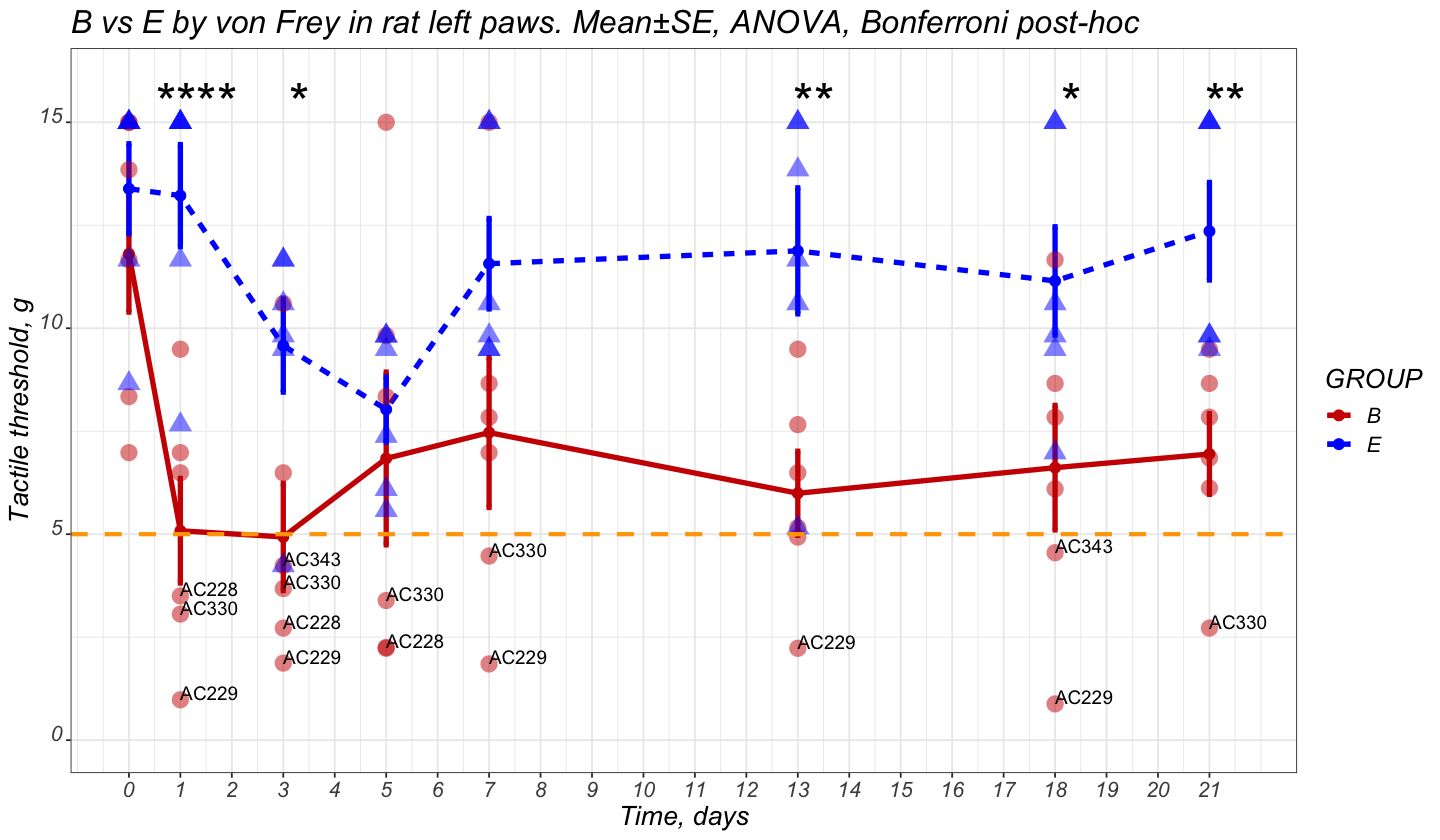

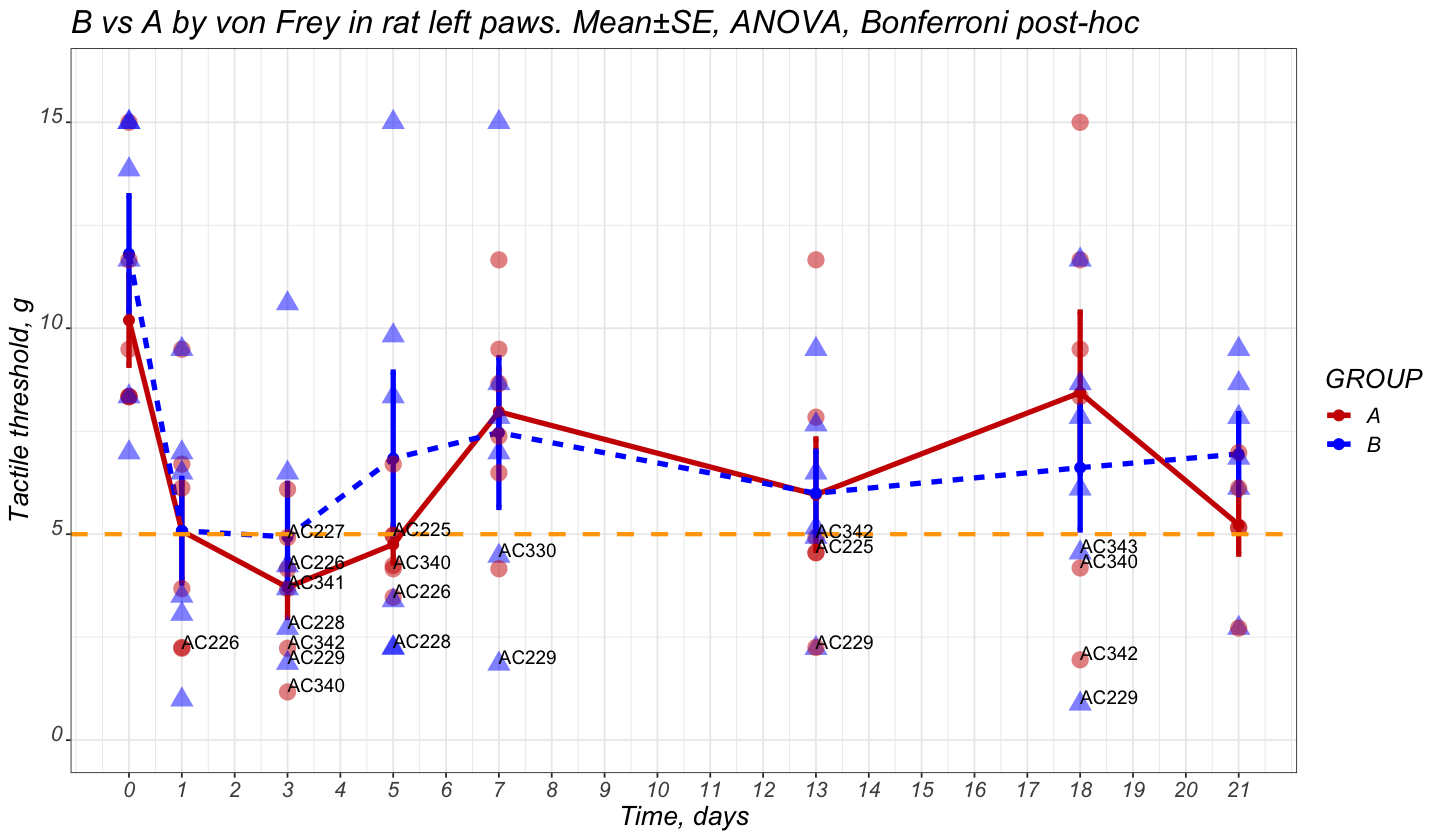

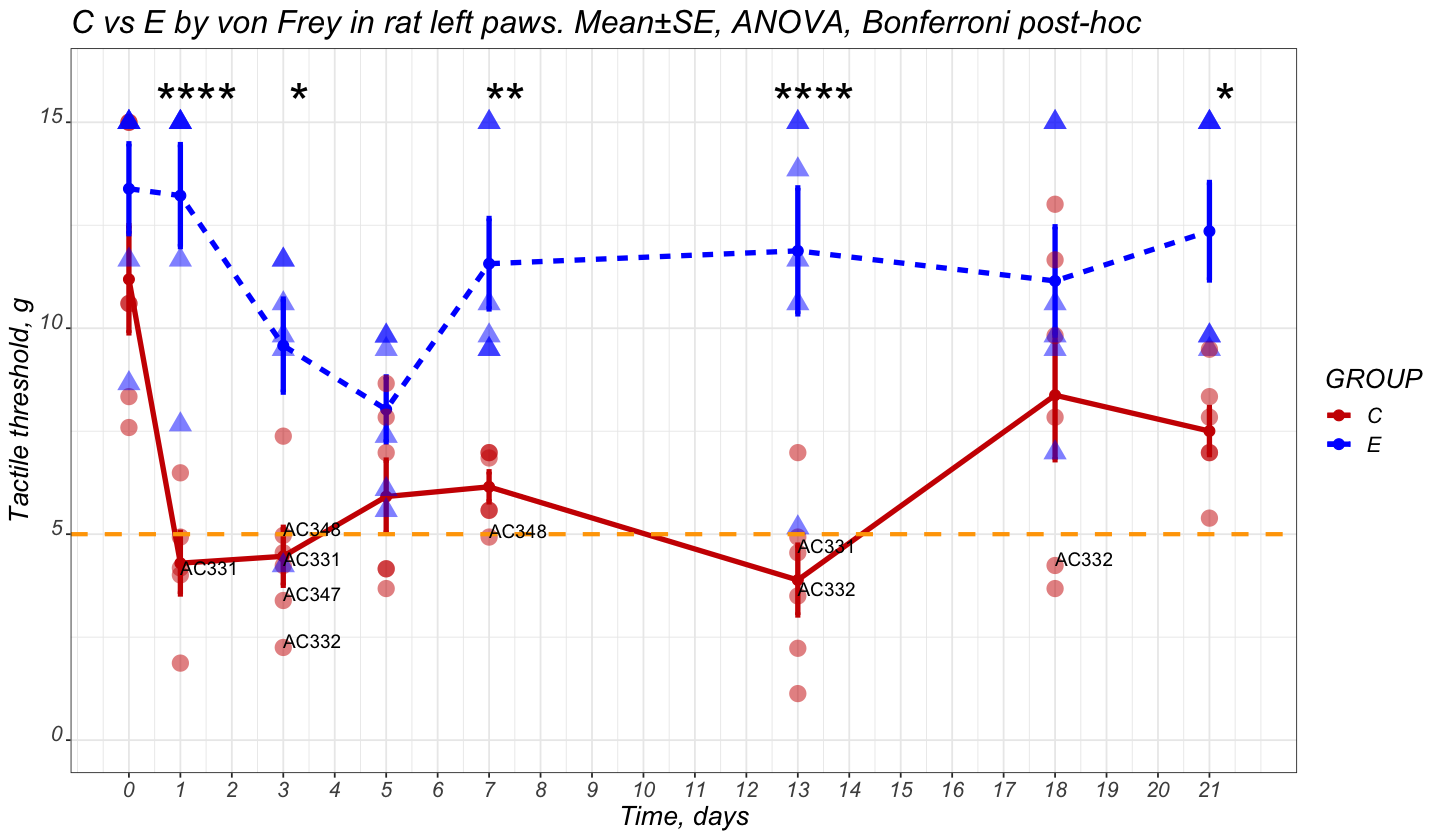

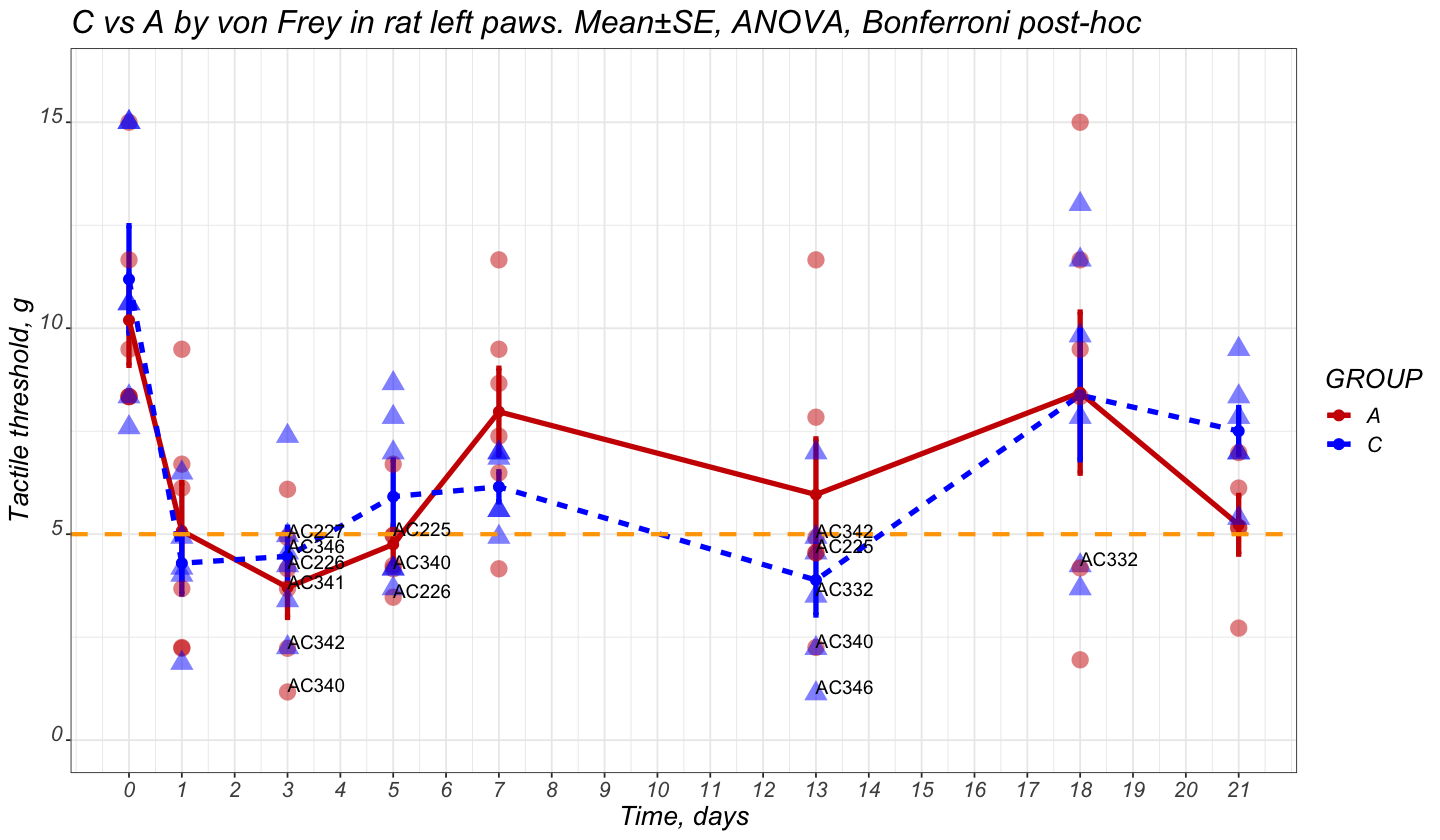

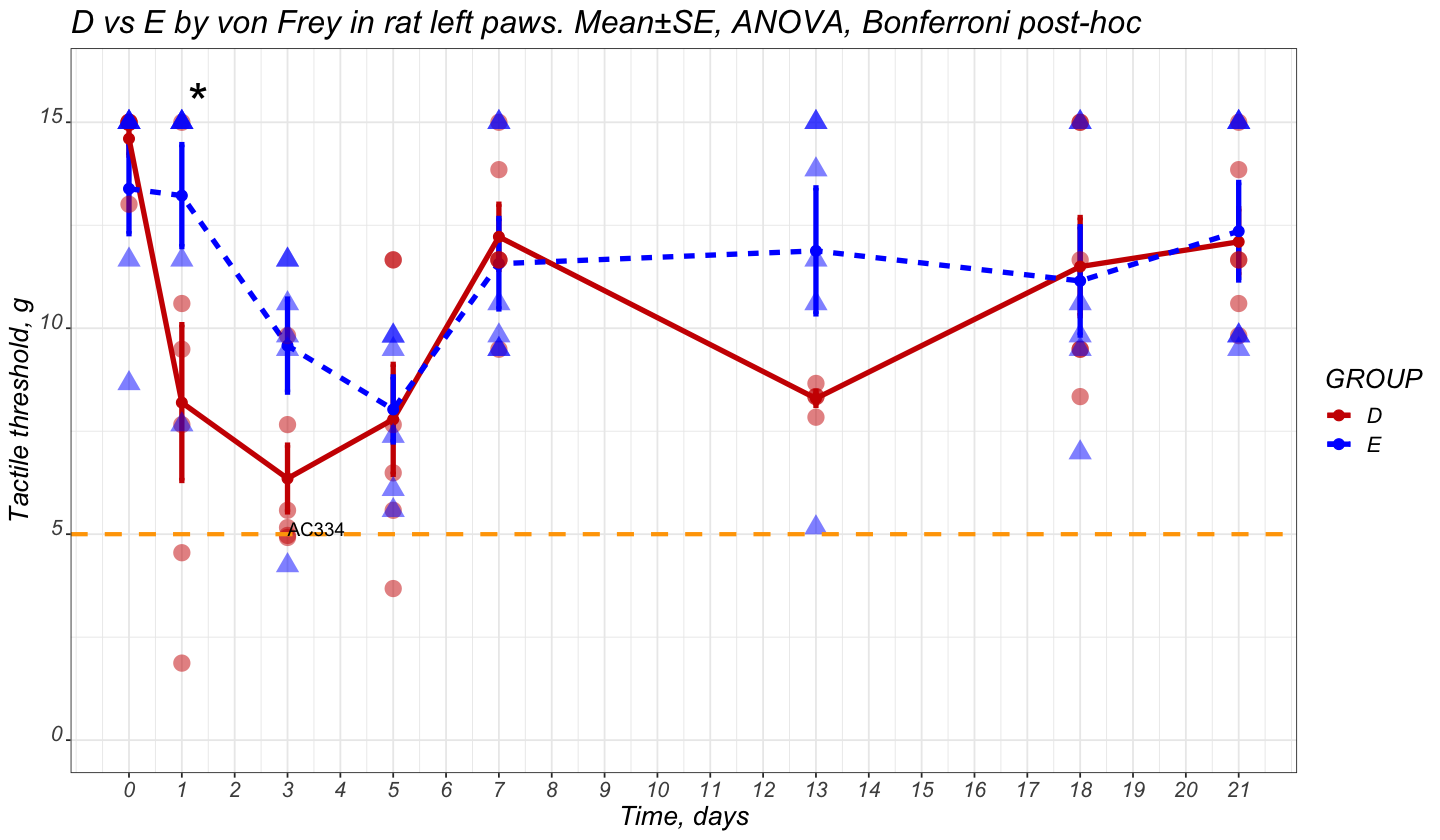

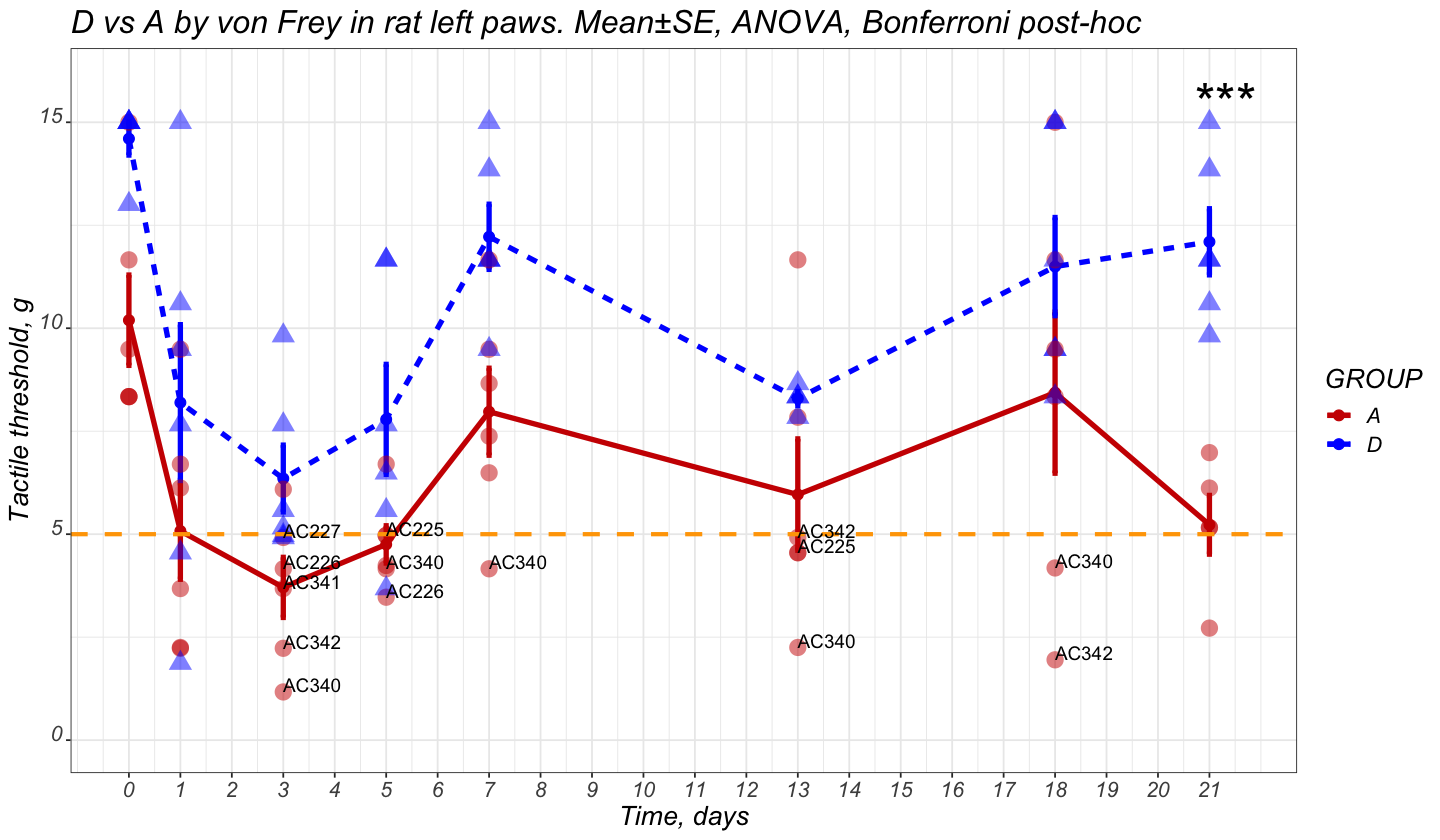

In [126]:
acPage(w1=12, h1=7)

print("Significance scores: * < 0.05; ** < 0.005; *** < 0.0005; **** < 0.00005")

for (i in 1:nrow(meta)){

lp_plot <- lp %>% filter ( GROUP == meta$TREATMENT[i] | GROUP == meta$REFERENCE[i] ) 
pwc.f <- pwc %>% filter( group1 == meta$TREATMENT[i] & group2 == meta$REFERENCE[i])
    
pp <- ggline(
            lp_plot, 
            y = "RESULT", 
            x = "TIMEPOINT", 
            color = "GROUP", 
            ylim = c(0, max_res + 1),
            linetype = "GROUP",
            size = 1.5, binwidth=0.8, 
            add = c("mean_se"),
            palette = c("red3", "blue1"),
            ) +  scale_x_continuous(breaks = 0:21*1) +
    stat_pvalue_manual( 
            pwc.f, 
            label = "p.adj.signif",
            position = position_dodge(0.6), 
            remove.bracket = T,
            size = 11,
            y.position = 15.5,
            hide.ns = T,
            color = "black"
            ) +
    geom_point(aes(shape = GROUP, color = GROUP, size = 10), alpha = 5/10, show.legend = F) +
    xlab(label = "Time, days") +
    ylab(label = "Tactile threshold, g") +
    ggtitle( sprintf( "%s vs %s by von Frey in %s %s paws. Mean\u00B1SE, ANOVA, %s post-hoc", 
                     meta$TREATMENT[i], meta$REFERENCE[i], species, tolower (paw), str_to_title(post_hoc_method))) +
    theme_bw() +
    geom_hline(yintercept=pain_threshold, linetype="dashed", color = "orange", size=1.2) +
    theme(text = element_text(size=16, color = "black", angle = 0, hjust = .5, vjust = 0, face = "italic")) +
    geom_text(aes(label=ifelse(label_id & RESULT <= pain_threshold,as.character(ANIMAL_ID),'')),hjust = 0, vjust = 0, size = 4, check_overlap = T)

    plot(pp)

    pdf(sprintf("vonFrey plot %s vs %s in %s %s paw.pdf", meta$TREATMENT[i], meta$REFERENCE[i], species, tolower (paw)), width = 12, height = 7)
        plot(pp)
    dev.off()
}

In [127]:
pwc <- pwc %>% 
    mutate (DAY = strtoi(DAY)) %>% 
    arrange (group1, group2, DAY)

for (i in 1:nrow(meta)){
    sprintf("Significance scores for %s vs %s, post-hoc %s", meta$TREATMENT[i], meta$REFERENCE[i], post_hoc_method) %>% print
    pwc %>% 
    filter(group1 == meta$TREATMENT[i] & group2 == meta$REFERENCE[i]) %>% 
    arrange (DAY) %>% 
    select (DAY, group1, group2, p, p.adj, p.adj.signif) %>%
    print
}

[1] "Significance scores for B vs E, post-hoc bonferroni"
# A tibble: 8 × 6
    DAY group1 group2          p     p.adj p.adj.signif
  <int> <chr>  <chr>       <dbl>     <dbl> <chr>       
1     0 B      E      0.347      1         ns          
2     1 B      E      0.00000249 0.0000149 ****        
3     3 B      E      0.00614    0.0369    *           
4     5 B      E      0.479      1         ns          
5     7 B      E      0.0154     0.0922    ns          
6    13 B      E      0.000557   0.00334   **          
7    18 B      E      0.00746    0.0448    *           
8    21 B      E      0.00147    0.00885   **          
[1] "Significance scores for B vs A, post-hoc bonferroni"
# A tibble: 8 × 6
    DAY group1 group2     p p.adj p.adj.signif
  <int> <chr>  <chr>  <dbl> <dbl> <chr>       
1     0 B      A      0.338     1 ns          
2     1 B      A      0.998     1 ns          
3     3 B      A      0.466     1 ns          
4     5 B      A      0.215     1 ns          
5     

### Kruskal-Wallis test 

Kruskal-Wallis test is a non-parametric alternative to the one-way ANOVA test. It extends the two-samples Wilcoxon test in the situation where there are more than two groups to compare. 

In [128]:
res.kruskal <- lp %>% 
    group_by(TIMEPOINT) %>% 
    kruskal_test(RESULT ~ GROUP)
res.kruskal

,TIMEPOINT,.y.,n,statistic,df,p,method
,<int>,<chr>,<int>,<dbl>,<int>,<dbl>,<chr>
1,0,RESULT,29,7.614129,4,0.107000,Kruskal-Wallis
2,1,RESULT,29,13.388578,4,0.009530,Kruskal-Wallis
3,3,RESULT,30,12.271386,4,0.015400,Kruskal-Wallis
4,5,RESULT,30,5.138245,4,0.273000,Kruskal-Wallis
5,7,RESULT,30,15.937318,4,0.003100,Kruskal-Wallis
6,13,RESULT,28,14.864020,4,0.004990,Kruskal-Wallis
7,18,RESULT,30,5.961328,4,0.202000,Kruskal-Wallis
8,21,RESULT,29,21.834862,4,0.000216,Kruskal-Wallis


## Effect size
The eta squared, based on the H-statistic, can be used as the measure of the Kruskal-Wallis test effect size. It is calculated as follow : 

    eta2[H] = (H - k + 1)/(n - k); 

where H is the value obtained in the Kruskal-Wallis test; k is the number of groups; n is the total number of observations (M. T. Tomczak and Tomczak 2014).

The eta-squared estimate assumes values from 0 to 1 and multiplied by 100 indicates the percentage of variance in the dependent variable explained by the independent variable.

The interpretation values commonly in published literature are: 0.01- < 0.06 (small effect), 0.06 - < 0.14 (moderate effect) and >= 0.14 (large effect).

In [129]:
lp %>% 
    group_by(TIMEPOINT) %>% 
    kruskal_effsize(RESULT ~ GROUP)

,TIMEPOINT,.y.,n,effsize,method,magnitude
,<int>,<chr>,<int>,<dbl>,<chr>,<ord>
1,0,RESULT,29,0.15058870,eta2[H],large
2,1,RESULT,29,0.39119073,eta2[H],large
3,3,RESULT,30,0.33085544,eta2[H],large
4,5,RESULT,30,0.04552980,eta2[H],small
5,7,RESULT,30,0.47749271,eta2[H],large
6,13,RESULT,28,0.47234870,eta2[H],large
7,18,RESULT,30,0.07845313,eta2[H],moderate
8,21,RESULT,29,0.74311927,eta2[H],large


## Multiple pairwise-comparisons
From the output of the Kruskal-Wallis test, we know that there is a significant difference between groups, but we don’t know which pairs of groups are different.

A significant Kruskal-Wallis test is generally followed up by Dunn’s test to identify which groups are different.

### Pairwise comparisons using Dunn’s test:

In [130]:
# Pairwise comparisons
pwc_dunn <- lp %>% 
    group_by(TIMEPOINT) %>% 
    dunn_test(RESULT ~ GROUP, p.adjust.method = post_hoc_method) 
pwc_dunn %>% filter(p.adj.signif != 'ns') %>% head(3)

TIMEPOINT,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<int>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,RESULT,A,E,6,6,2.840375,0.004506046,0.04506046,*
1,RESULT,B,E,6,6,2.857384,0.004271491,0.04271491,*
1,RESULT,C,E,5,6,3.013066,0.002586226,0.02586226,*


It’s also possible to use the Wilcoxon’s test to calculate pairwise comparisons between group levels with corrections for multiple testing.

In [131]:
pwc_wilcox <- lp %>% 
    group_by(TIMEPOINT) %>% 
    wilcox_test(RESULT ~ GROUP, p.adjust.method = post_hoc_method)

(pwc_wilcox %>% filter(p.adj.signif != 'ns'))

TIMEPOINT,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<int>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
7,RESULT,C,D,6,6,0,0.005,0.046,*
7,RESULT,C,E,6,6,0,0.005,0.048,*
21,RESULT,B,D,6,6,0,0.005,0.050,*
21,RESULT,C,D,6,6,0,0.005,0.049,*


## Report
There was a statistically significant differences between treatment groups as assessed using the Kruskal-Wallis test (p = 0.018). Pairwise Wilcoxon test between groups showed that only the difference between trt1 and trt2 group was significant (Wilcoxon’s test, p = 0.027)

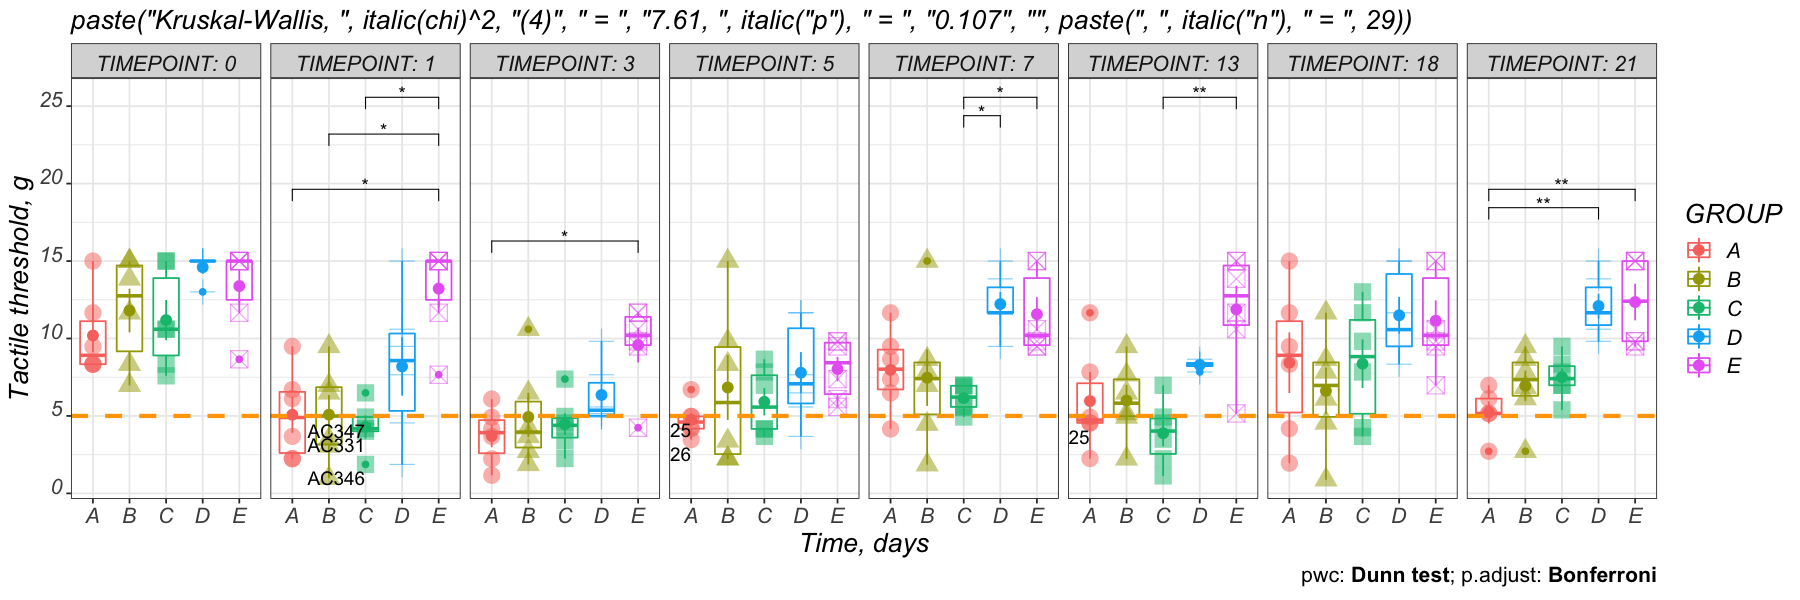

In [132]:
# Visualization: box plots with p-values

acPage(w1=15, h1=5)
#res.kruskal <- lp %>% group_by(TIMEPOINT) %>% kruskal_test(RESULT ~ GROUP)
#pwc_dunn <- lp %>%  group_by(TIMEPOINT) %>% dunn_test(RESULT ~ GROUP, p.adjust.method = "bonferroni") 
pwc_dunn <- pwc_dunn %>% add_xy_position(x = "GROUP")

p1 <- lp %>% 
        ggboxplot(x = "GROUP", y = "RESULT",  add = c("mean_se"), color = "GROUP") +
        stat_pvalue_manual(pwc_dunn, hide.ns = TRUE) +
        labs(
        subtitle = get_test_label(res.kruskal, detailed = T, correction = post_hoc_method),
        caption = get_pwc_label(pwc_dunn),
        type = "expresion"
        ) +
geom_point(aes(shape = GROUP, color = GROUP, size = 10), alpha = 5/10, show.legend = F) +
xlab(label = "Time, days") +
ylab(label = "Tactile threshold, g") +
theme_bw() +
geom_hline(yintercept=pain_threshold, linetype="dashed", color = "orange", size=1.2) +
theme(text = element_text(size=16, color = "black", angle = 0, hjust = .5, vjust = 0, face = "italic")) +
facet_grid( ~ TIMEPOINT, labeller = "label_both") +
geom_text(aes(label=ifelse(label_id & RESULT<=pain_threshold,as.character(ANIMAL_ID),'')), hjust = 1, vjust = 1.5, size = 4, check_overlap = T)

plot(p1)

### Save results

In [133]:
sprintf("Save results in %s file", res_file)

[1] "Save results in result.test_data.xlsx file"

In [134]:
write_xlsx(list(data = dt, meta = meta, ANOVA = pwc, Kruskal = res.kruskal, Dunn = pwc_dunn, Wilcox = pwc_wilcox), res_file)

In [135]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS/LAPACK: /Users/achernov/opt/anaconda3/envs/PyR4/lib/libopenblasp-r0.3.18.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] emmeans_1.7.2     lubridate_1.8.0   writexl_1.4.0     readxl_1.3.1     
 [5] DescTools_0.99.44 rstatix_0.7.0     forcats_0.5.1     stringr_1.4.0    
 [9] purrr_0.3.4       tidyr_1.1.4       tibble_3.1.6      tidyverse_1.3.1  
[13] dplyr_1.0.8       ggpubr_0.4.0      ggplot2_3.3.5     readr_2.1.2      

loaded via a namespace (and not attached):
 [1] fs_1.5.2          httr_1.4.2        ggsci_2.9         repr_1.1.4       
 [5] tools_4.1.2       backports_1.4.1   utf8_1.2.2        R6_2.5.1         
 [9] DBI_1.1.2         colorspace_2.0-2  withr_2.4.3       tidyselect_1.1.1 
[13] Exact_3.1         compiler_4.1.2    cli